# Rounding tests

Testing analyses of rounded data

In [1]:
# %config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
from numpyro.contrib.funsor import config_enumerate

from jax.scipy.special import digamma, polygamma, logit, expit, erf

import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

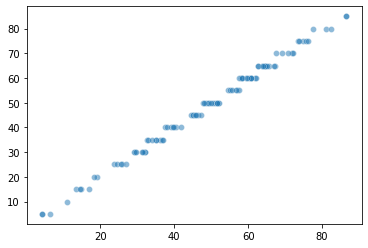

In [2]:
# first data that is all rounded to five

n_obs = 100
rg = default_rng(12345)

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

x_true = rg.beta(3,3,n_obs)*100
x_obs = round_to_five(x_true)


sns.scatterplot(x_true, x_obs,alpha=.5)

In [3]:
def spread_vec(x, step_size):
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    return probs/jnp.sum(probs)


def logit_normal_cdf(mu, sigma, x):
    inner = (logit(x) - mu)/ jnp.sqrt(2*jnp.power(sigma, 2))
    return .5 * (1 + erf(inner))


def beta_approx_cdf(a, b, x):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu_est = digamma(a) - digamma(b)
    sigma_est = jnp.sqrt(polygamma(1, a) + polygamma(1, b))
    
    return logit_normal_cdf(mu_est, sigma_est, x)

def beta_approx_params(a, b):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu_est = digamma(a) - digamma(b)
    sigma_est = jnp.sqrt(polygamma(1, a) + polygamma(1, b))
    
    return mu_est, sigma_est

# def beta_approx_cdf(mu, k, x):
#     # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
#     a = mu*k
#     b = (1-mu)*k
#     K_a = a
#     K_b = ((a-1)/(a*b-1)^(1/a))
    
#     return k_a, k_b

def beta_approx_cdf_norm(a, b, x):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu = a/(a+b)
    sigma = jnp.sqrt((a*b)/(jnp.power(a+b,2)*(a+b+1.)))
    
    return dist.Normal(mu, sigma).cdf(x)

def make_cuts(start, stop, step_size):
    cut_points = np.arange(start, stop, step_size)+step_size/2
    upper_pts = jnp.clip(cut_points + step_size/2, a_max=100, a_min=0)
    lower_pts = jnp.clip(cut_points - step_size/2, a_max=100, a_min=0)
    return upper_pts, lower_pts

def categorical_probs(a, b, step_size, max_size=100):

    upper_pts, lower_pts = make_cuts(0,100,step_size)
    
#     prob_dist = beta_approx_cdf(a,b) # replace with Kumaraswamy approx.
    probs = beta_approx_cdf(a,b,upper_pts/100.) - beta_approx_cdf(a,b,lower_pts/100.)
    return probs

def categorical_probs_spread(a, b, step_size, max_size=100):
    x = categorical_probs(a, b, step_size, max_size)
    
    return spread_vec(x, step_size)


# def rounding_model(x_obs, step_size):
#     mu1 = numpyro.sample("mu", dist.Beta(1,1))
#     k1 = numpyro.sample("k", dist.HalfCauchy(10))
#     mu, sigma = beta_approx_params(mu1*k, (1-mu1)*k)
# #     x_true_cp = categorical_probs_spread(mu*k, (1-mu)*k, step_size)


# #     with numpyro.plate("data", x_obs.shape[0]):
# # #         numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs)
# #         numpyro.sample("x", dist.TransformedDistribution(dist.Normal(mu, sigma), transforms=dist.transforms.SigmoidTransform())
# #                    , obs=x_obs/100.)
        
# def rounding_model(x_obs, step_size):
#     mu = numpyro.sample("mu", dist.Normal(0,3))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))

#     with numpyro.plate("data", x_obs.shape[0]):
#         numpyro.sample("x", dist.TransformedDistribution(dist.Normal(mu, sigma), transforms=dist.transforms.SigmoidTransform())
#                        , obs=x_obs/100.)
    


In [18]:
categorical_probs_spread(3, 3, 10)

DeviceArray([0.00671282, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.05268684, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.11080319, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.1539123 , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.17588484, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.17588484, 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.1539123 , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.

In [4]:
# x = jnp.linspace(.01,.99,1000)
# mu = .9
# k = 30
# z = .1
# sns.scatterplot(y = dist.Beta(mu*k, (1-mu)*k).cdf(x), x = beta_approx_cdf(mu*k, (1-mu)*k,x))
# sns.scatterplot(y = dist.Beta(mu*k, (1-mu)*k).cdf(x), x = beta_approx_cdf_norm(mu*k, (1-mu)*k,x))

# print(dist.Beta(mu*k, (1-mu)*k).cdf(z))
# print(beta_approx_cdf(mu*k, (1-mu)*k, z))
# print(beta_approx_cdf_norm(mu*k, (1-mu)*k,z))
# # mcmc_test.print_summary()

# upper_pts, lower_pts = make_cuts(0,100, 5)
# probs = logit_normal_cdf(-1, sigma, upper_pts/100.) - logit_normal_cdf(-1, sigma, lower_pts/100.)

# probs.shape
# expit(-.07)
# dist.TransformedDistribution(dist.Normal(0, 1), transforms=dist.transforms.SigmoidTransform()).log_prob(.5)
beta_approx_params(3, 3)

(DeviceArray(0., dtype=float32, weak_type=True),
 DeviceArray(0.88874525, dtype=float32))

In [5]:
mcmc_test = MCMC(NUTS(rounding_model), 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs, 5)    
mcmc_test.print_summary()

NameError: name 'rounding_model' is not defined

Now to allow for different rounding policies and infer the rounding policy being used.

This code works (3/27/21, 4:29 PM)!

But it doesn't work when the distribution is skewed, because the normal distribution approximation I'm using is no good.

In [19]:
def rounding_mixture_model(x_obs):
    
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(3)))
    steps = jnp.array([1, 5, 20])
    
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    theta_vec = jnp.reshape(theta, (-1,3))

    with numpyro.plate("data", x_obs.shape[0]):
        
        x_true_cp_stack = jnp.stack([ categorical_probs_spread(mu*k, (1.-mu)*k, step_size)  for step_size in steps])

        x_true_cp = jnp.matmul(theta_vec, x_true_cp_stack)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs) # need to spread the values instead of padding

In [21]:
mcmc_test = MCMC(NUTS(rounding_mixture_model), num_warmup = 1000, num_samples=1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs)   

TypeError: take_along_axis indices must be of integer type, got float32

In [19]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      5.82      0.94      5.75      4.09      7.21    984.29      1.00
        mu      0.51      0.02      0.51      0.48      0.54    799.73      1.00
  theta[0]      0.01      0.01      0.01      0.00      0.03   1188.36      1.00
  theta[1]      0.95      0.03      0.96      0.91      1.00    757.92      1.00
  theta[2]      0.03      0.03      0.03      0.00      0.08    785.96      1.00

Number of divergences: 0


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

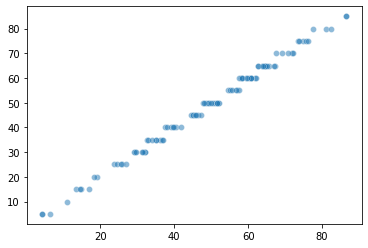

In [9]:
# smaller, narrower new data rounded to 5

n_obs = 100
rg = default_rng(12345)

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_ten(x):
    return jnp.round(x/10,0)*10

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

x_true = rg.beta(3,3,n_obs)*100
x_obs = round_to_five(x_true)


sns.scatterplot(x_true, x_obs,alpha=.5)

In [14]:
import jax

def cat_probs_norm(mu, sigma, step_size, max_size=100):

    upper_pts, lower_pts = make_cuts(0,100,step_size)
    
    prob_dist = dist.StudentT(3, mu, sigma) # on (0,1) scale
    probs = prob_dist.cdf(upper_pts/100.) - prob_dist.cdf(lower_pts/100.)
    return probs


vec_cat_probs = jax.vmap(cat_probs_norm, in_axes = (0, None, None))
vec_spread_vec = jax.vmap(spread_vec, in_axes = (0, None))

def vec_cat_probs_spread(mu, sigma, step_size, max_size=100):
    return vec_spread_vec(vec_cat_probs(mu, sigma, step_size), step_size)


def rounding_model_latent(x_obs, step_size):
#     mu = numpyro.sample("mu", dist.Beta(1,1))
#     k = numpyro.sample("k", dist.HalfCauchy(10))
    mu = .50
    k = 6.
    
    with numpyro.plate("data", x_obs.shape[0]):
        x_true = numpyro.sample("x_true", dist.Beta(mu*k, (1-mu)*k))
        x_true_cp = vec_cat_probs_spread(x_true, .01, step_size)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs)

In [16]:
mcmc_test = MCMC(NUTS(rounding_model_latent, target_accept_prob=.80), num_warmup=1000, num_samples=1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs, 5)   

TypeError: take_along_axis indices must be of integer type, got float32

In [ ]:
mcmc_test.print_summary()

Having vectorized things with `vmap()` it seems to initialize well, produces a reasonable answer and samples reasonably quickly, but still produces lots of divergences.

In [56]:
# def rounding_model_latent(x_obs, step_size):
#     mu = numpyro.sample("mu", dist.Beta(1,1))
#     k = numpyro.sample("k", dist.HalfCauchy(10))
    
#     with numpyro.plate("data", x_obs.shape[0]):
#         x_true = numpyro.sample("x_true", dist.Beta(mu*k, (1-mu)*k))
#         x_true_cp = vec_cat_probs_spread(x_true, .01, step_size)
#         numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs)

DeviceArray(-9.527151, dtype=float32)

In [12]:
def reshape_theta(theta, n_obs, n_steps, n_categories):
    theta_vec = jnp.reshape(theta, (-1, n_steps))
    theta_obj = theta_vec.repeat(n_obs, axis=-1)
    theta_obj = jnp.reshape(theta_obj.repeat(n_categories, axis=-1), (n_steps, n_obs, n_categories))
    
    return theta_obj

def rounding_mixture_model_reg(x_obs):
    n_obs = x_obs.shape[0]
    steps = jnp.array([5])
#         steps = jnp.array([1, 5, 10])
    #     theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(len(steps))))
    theta = jnp.array(1.)


    
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    
    theta_obj = reshape_theta(theta, n_obs, len(steps), 100)
    
    with numpyro.plate("data", n_obs):

        x_true = numpyro.sample("x_true", dist.Beta(mu*k, (1-mu*k)))
        x_true_cp_stack = jnp.stack([ vec_cat_probs_spread(x_true, .02, step_size) for step_size in steps])
        
#         x_true_cp = jnp.sum(x_true_cp_stack*theta_obj, axis=0)
        x_true_cp = jnp.exp(jax.scipy.special.logsumexp(jnp.log(x_true_cp_stack) + jnp.log(theta_obj), axis=-3))
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs)
    return None


In [13]:
mcmc_test = MCMC(NUTS(rounding_mixture_model_reg, target_accept_prob=.90), num_warmup =1000, num_samples = 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs)   

TypeError: take_along_axis indices must be of integer type, got float32

In [ ]:
mcmc_test.print_summary()

In [261]:
dist.Dirichlet(jnp.ones(1)).sample(random.PRNGKey(0))

DeviceArray([0.9999999], dtype=float32)

(2, 3)
(2, 3, 100)


<AxesSubplot:>

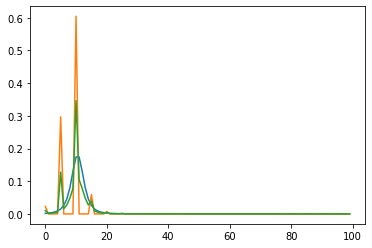

In [296]:
steps = [1,5]
x_true = jnp.array([.11,.5,.7])
z = jnp.stack([ vec_cat_probs_spread(x_true, .02, step_size, max_size=100)  for step_size in steps])
theta = jnp.array([.6,.4])
theta_vec = jnp.reshape(theta, (2,-1))

test_obj = theta_vec.repeat(3,axis=-1)
print(test_obj.shape)
print(z.shape)
test_obj = jnp.reshape(test_obj.repeat(100, axis=-1), (2,-1,100))

cat_preds = jnp.sum(z*test_obj, axis=-3)
jnp.sum(cat_preds, axis=-1) # sum to 1 which seems right ...

sns.lineplot(x=jnp.arange(0,100), y=z[0,0,:])
sns.lineplot(x=jnp.arange(0,100), y=z[1,0,:])
sns.lineplot(x=jnp.arange(0,100), y=cat_preds[0,:])


<AxesSubplot:>

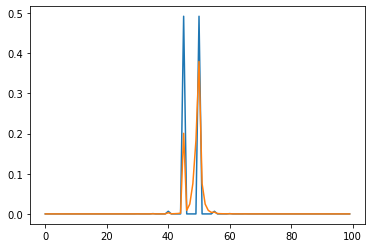

In [274]:

test_obj = reshape_theta(theta, 3, 2, 100)

# cat_preds = jnp.sum(z*test_obj, axis=-3)
cat_preds = jnp.exp(jax.scipy.special.logsumexp(jnp.log(z) + jnp.log(test_obj), axis=-3))
jnp.sum(cat_preds, axis=-1) # sum to 1 which seems right ...

sns.lineplot(x=jnp.arange(0,100), y=z[1,1,:])
sns.lineplot(x=jnp.arange(0,100), y=cat_preds[1,:])

In [437]:
## lots of people saying us kumaraswamy -- but its approximation sucks
## based on https://www.johndcook.com/blog/2009/11/24/kumaraswamy-distribution/ <-- warns it might be poor
def beta_to_kumaraswamy(a, b):
    if (a>1.) + (b>1.)==2.:
        beta_mode = (a-1.) / (a + b - 2.)
    else:
        beta_mode = np.select(
            [(a <= 1.) + (b > 1.)==2, (b <= 1.) + (a > 1)==2, (a<1.) + (b<1.)==2 ],
            [0, 1., 1/2],
            default = 1.
        )
    a_k = jnp.array(a)
    b_k = 1/a+(1/a)*((a-1)/jnp.power(beta_mode, a))
    return a_k, b_k

def kumaraswamy_cdf(a, b, x):
#     1 – (1 – x^a)^b
    inner = 1 - jnp.power(x,a)
    return 1 - jnp.power(inner, b)

def beta_approx_cdf_kumaraswamy(a,b,x):
    a_k, b_k = beta_to_kumaraswamy(a, b)
    
    return kumaraswamy_cdf(a_k, b_k, x)

beta_approx_cdf_kumaraswamy(3, 3, .5)

DeviceArray(0.53077734, dtype=float32)

In [453]:
a = .2*10
b = .8*10
x = .5
print(beta_approx_cdf_kumaraswamy(a, b, x))
print(beta_approx_cdf(a,b).cdf(x))
print(dist.Beta(a,b).cdf(x))

0.999913
0.9935672
0.9804687


In [462]:
jnp.sum(categorical_probs(100.,3., step_size=5))

DeviceArray(1., dtype=float32)

In [623]:
def spread_vec(x, step_size):
    n_vecs = x.shape[-2]
    print(n_vecs)
    base_steps = x.shape[-1]
    print(base_steps)
    x_split = jnp.array(jnp.split(x, base_steps, axis=-1))
    x_split = jnp.squeeze(x_split)
    print(x_split.shape)
#     pad = jnp.zeros([step_size-1, n_vecs])
#     pad = jnp.zeros([n_vecs, step_size])
#     print(pad.shape)
    padded = jnp.pad(x_split, pad_width=(0,step_size-1), constant_values=0.)
#     return jnp.concatenate((x_split,pad), axis=-1)
    return padded
#     return(padded)
#     return jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()

## getting all confused 
a = jnp.array([[1,2,3,4],[1,2,3,4]] )
b = jnp.split(a, 4, axis=-1)
b
# c = [jnp.split(jnp.squeeze(i),4) for i in b]
# pad = jnp.zeros(4)

# jnp.stack([jnp.concatenate((i[j],pad)) for i in c for j in range(0,4)])

# pad = jnp.zeros([4,1])
# jnp.concatenate((b[,0],))
# z
# w = jnp.pad(z, pad_width=[0,5], constant_values=0.)



[DeviceArray([[1],
              [1]], dtype=int32),
 DeviceArray([[2],
              [2]], dtype=int32),
 DeviceArray([[3],
              [3]], dtype=int32),
 DeviceArray([[4],
              [4]], dtype=int32)]

In [713]:
dist.Categorical(jnp.array([[.1,.2,.3,.6], [.1,.2,.3,.6]])).sample(random.PRNGKey(1))

Buffer([2, 3], dtype=int32)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

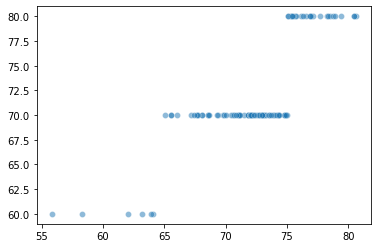

In [45]:
# smaller, narrower new data rounded to 5

n_obs = 100
rg = default_rng(12345)

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_ten(x):
    return jnp.round(x/10,0)*10

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

x_true = rg.beta(.72*100,(1-.72)*100,n_obs)*100
x_obs = round_to_ten(x_true)


sns.scatterplot(x_true, x_obs,alpha=.5)

# Gelman's approach

https://mc-stan.org/docs/2_28/stan-users-guide/bayesian-measurement-error-model.html

In [5]:
# this is gelman's approach and it works the best
# but not clear how to make this work if there are multiple forms of rounding going on.        

# def roundmodel_gelman(y_obs): ## this is what I had before ...
#     mu = numpyro.sample("mu", dist.Beta(1,1))
#     k = numpyro.sample("k", dist.HalfCauchy(10))
    
#     scale = 10.
#     scale_transformed = scale/100.
#     y_obs_transformed = y_obs/100.    
    
#     with numpyro.plate("data", y_obs.shape[0]):

#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_err = (y_err - .50)*scale_transformed

#         y_true = numpyro.sample("y_true", dist.Beta(mu*k, (1-mu)*k))
#         numpyro.sample("y_hat", dist.Normal(y_true + y_err, .01), obs=y_obs_transformed)
 
    
def roundmodel_gelman(y_obs): # this is right?
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    
    scale = 10.
    scale_transformed = scale/100.
    y_obs_transformed = y_obs/100.    
    
    with numpyro.plate("data", y_obs.shape[0]):

        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_err = (y_err - .50)*scale_transformed
        z = y_obs_transformed + y_err

        y_true = numpyro.sample("y_true", dist.Beta(mu*k, (1-mu)*k), obs=z)
        

mcmc_test = MCMC(NUTS(roundmodel_gelman, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc_test.run(random.PRNGKey(0), x_obs)   
# mcmc_test.print_summary()

sample: 100%|██████████| 2000/2000 [00:03<00:00, 562.06it/s, 15 steps of size 3.93e-01. acc. prob=0.82] 


In [6]:
# mcmc_test.print_summary()

In [7]:
%run -i 'model_helpers.py'
az_test = make_arviz_data(mcmc_test, roundmodel_gelman, x_obs) # see model_helpers.py


<AxesSubplot:xlabel='y_true / y_true'>

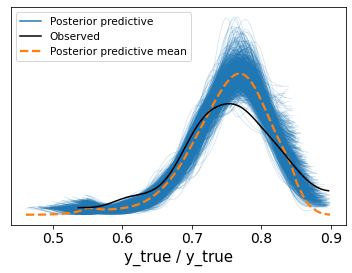

In [8]:
# az_test.posterior["yhat_rounded"] = az_test.posterior_predictive.y_true + az_test.posterior.y_err
az.plot_ppc(az_test)

In [49]:
def roundmodel_gelman_discrete(y_obs): # updated this to match above
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    scales = jnp.array([1., 5., 10.])
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(len(scales))))

    y_obs_transformed = y_obs/100.   

    with numpyro.plate("data", y_obs.shape[0]):
        ## need some way to get this to update theta
        z = numpyro.sample("z", dist.Categorical(theta))
    
        rem_5 = jnp.remainder(y_obs, 5.)
        rem_10 = jnp.remainder(y_obs, 10.)
        z = jnp.where(rem_5!=0, 0, jnp.where(rem_10!=0, 1, z)) # not converging

        scale_transformed = scales[z]/100.

        y_err = numpyro.sample("y_err", dist.Beta(1,2)) # non-uniform
        y_err = (y_err - .50)*scale_transformed

        y_true = numpyro.sample("y_true", dist.Beta(mu*k, (1-mu)*k), obs=y_obs_transformed + y_err)


In [50]:
kernel = DiscreteHMCGibbs(NUTS(roundmodel_gelman_discrete), modified=True)
mcmc_test = MCMC(kernel, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_test.run(random.PRNGKey(0), x_obs)

sample: 100%|██████████| 4000/4000 [00:09<00:00, 433.23it/s, 31 steps of size 1.38e-01. acc. prob=0.94]


In [51]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k     81.98     14.03     80.74     59.51    105.28    386.43      1.00
        mu      0.71      0.01      0.71      0.70      0.72    244.03      1.00
  theta[0]      0.47      0.28      0.46      0.00      0.89     28.70      1.00
  theta[1]      0.53      0.28      0.54      0.11      1.00     28.70      1.00
  y_err[0]      0.36      0.23      0.34      0.00      0.69   4171.34      1.00
  y_err[1]      0.21      0.18      0.17      0.00      0.47   3493.17      1.00
  y_err[2]      0.51      0.25      0.52      0.11      0.90   2454.09      1.00
  y_err[3]      0.36      0.23      0.34      0.00      0.69   4152.13      1.00
  y_err[4]      0.36      0.23      0.34      0.00      0.70   4135.51      1.00
  y_err[5]      0.37      0.23      0.34      0.00      0.70   4131.06      1.00
  y_err[6]      0.22      0.18      0.16      0.00      0.49   2606.95      1.00
  y_err[7]      0.36      0

This samples but seemingly can't learn about $z$ properly

My new idea is to use a logistic normal approximation to the Dirichlet for a 2d Dirichlet (which is itself just a beta distribtion).

<AxesSubplot:ylabel='Density'>

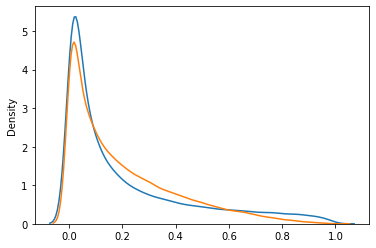

In [96]:
from jax.scipy.special import digamma, polygamma, logit, expit, erf
# trigamma(x) = polygamma(1,x)
mu_true = .
k_true = 3

a = mu_true*k_true
b = (1-mu_true)*k_true

mu_est = digamma(a) - digamma(b)
sigma = polygamma(1, a) + polygamma(1, b)

vals = np.random.normal(mu_est, jnp.sqrt(sigma), 100000)
beta_vals = np.random.beta(a, b, 100000)

sns.kdeplot(x=expit(vals))
sns.kdeplot(x=beta_vals)

<AxesSubplot:ylabel='Density'>

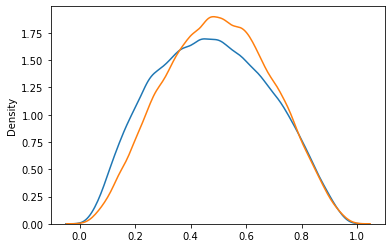

In [230]:
vals = np.random.normal(-.11, .96, 100000)
beta_vals = np.random.beta(3, 3, 100000)

sns.kdeplot(x=expit(vals))
sns.kdeplot(x=beta_vals)

In [259]:


def logit_normal_cdf(mu, sigma, x):
    inner = (logit(x) - mu)/ (jnp.sqrt(2*jnp.power(sigma, 2)))
    return .5 * (1 + erf(inner))


def beta_approx_cdf(a, b, x):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu_est = digamma(a) - digamma(b)
    sigma_est = polygamma(1, a) + polygamma(1, b)
    
    return logit_normal_cdf(mu_est, sigma_est, x)


beta_approx_cdf(3, 3, .7)
# grad_test = jax.grad(jax.scipy.special.betainc)

DeviceArray(0.8582989, dtype=float32)

In [108]:
jnp.remainder(x_obs, 10.)==0

DeviceArray([False, False,  True, False, False, False, False, False,
             False,  True, False, False, False, False, False, False,
              True, False, False,  True,  True, False, False, False,
             False, False, False,  True, False, False,  True, False,
             False, False, False,  True, False, False,  True, False,
             False, False,  True, False, False, False, False, False,
             False, False,  True, False, False, False, False, False,
             False, False,  True,  True, False, False, False, False,
             False,  True, False, False, False, False, False,  True,
              True, False, False, False, False, False, False, False,
             False, False,  True, False, False, False, False, False,
              True, False, False, False, False, False, False, False,
             False, False,  True, False], dtype=bool)

In [96]:
rem_5 = jnp.remainder(x_obs, 5.)
rem_10 = jnp.remainder(x_obs, 10.)
z = jnp.ones(100)*2
z = jnp.where(rem_5!=0, 0, jnp.where(rem_10!=0, 1, z))
dist.Categorical(jnp.array([.5,.25,.25])).sample(random.PRNGKey(0), (10,))

DeviceArray([0, 1, 0, 0, 0, 0, 0, 0, 2, 1], dtype=int32)